In [79]:
import pandas as pd
import scipy as sc
import numpy as np
import os
import json

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colors import colorConverter
import seaborn as sns

%load_ext autoreload
%autoreload 2
%load_ext blackcellmagic
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The blackcellmagic extension is already loaded. To reload it, use:
  %reload_ext blackcellmagic


Project-level imports.

In [93]:
from constants import guest_types
from constants import colors
from constants import systems
from bootstrap import bootstrap
from bootstrap import dG_bootstrap
from bootstrap import dH_bootstrap
import plotting

# Load in results

In [103]:
bgbg = pd.read_csv("results/bgbg_tip3p_by_orientation.csv")
bgbg_combined = pd.read_csv("results/bgbg_tip3p_combined.csv")

bg2bg2 = pd.read_csv("results/bg2bg2_tip3p_by_orientation.csv")
bg2bg2_combined = pd.read_csv("results/bg2bg2_tip3p_combined.csv")

smirnoff = pd.read_csv("results/smirnoff_by_orientation.csv")
smirnoff_combined = pd.read_csv("results/smirnoff_combined.csv")

experimental = pd.read_csv("results/experimental.csv")

# Plot comparisons

In [104]:
def scatter(df, x, y, xerr, yerr, xlabel, ylabel, colors, name, statistics_file_prefix):
    fig, ax = plt.subplots(1, figsize=(6 * 1.2, 6))

    for index, typ in enumerate(df["Type"].unique()):
        tmp = df[df["Type"] == typ]        
        ax.errorbar(
            tmp[x],
            tmp[y],
            xerr=tmp[xerr],
            yerr=tmp[yerr],
            fmt="o",
            markersize=8,
            markeredgecolor="k",
            markeredgewidth=0.2,
            elinewidth=1.0,
            ecolor="0.5",
            color=colors[typ],
        )

        type_statistics = pd.read_csv(f"results/{statistics_file_prefix}_{typ}.csv")
        type_statistics.index = type_statistics["Unnamed: 0"]
        type_string = f"R$^2$ = {type_statistics['mean']['R**2']:0.2f}"
        artist = ax.annotate(
            type_string,
            (0.98, 0.02 + 0.05 * index),
            xytext=(4, -4),
            xycoords="axes fraction",
            textcoords="offset points",
            horizontalalignment="right",
            verticalalignment="bottom",
            size=14,
            color=colors[typ],
            transform=ax.transAxes,
        )

    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.plot([-50, 50], [-50, 50], ls="-", c="0.3", zorder=-1, lw="0.5")
    ax.set_ylim(-10, 5)
    ax.set_xlim(-10, 5)

    statistics = pd.read_csv(f"results/{statistics_file_prefix}_overall.csv")
    statistics.index = statistics["Unnamed: 0"]
    
    text = f"RMSE = {statistics['mean']['RMSE']:0.2f} [{statistics['mean']['RMSE']-1.96*statistics['sem']['RMSE']:0.2f}, {statistics['mean']['RMSE']+1.96*statistics['sem']['RMSE']:0.2f}]"
    text += "\n"
    text += f"R$^2$ = {statistics['mean']['R**2']:0.2f} [{statistics['mean']['R**2']-1.96*statistics['sem']['R**2']:0.2f}, {statistics['mean']['R**2']+1.96*statistics['sem']['R**2']:0.2f}]"
    left, width = .25, .5
    bottom, height = .25, .5
    right = left + width
    top = bottom + height
    ax.annotate(
        text,
        (0.01, 0.99),
        xytext=(4, -4),
        xycoords="axes fraction",
        textcoords="offset points",
        horizontalalignment="left",
        verticalalignment="top",
        size=14,
        backgroundcolor="white",
        transform=ax.transAxes,
    )
    fig.savefig(f"figures/{name}", bbox_inches="tight")    

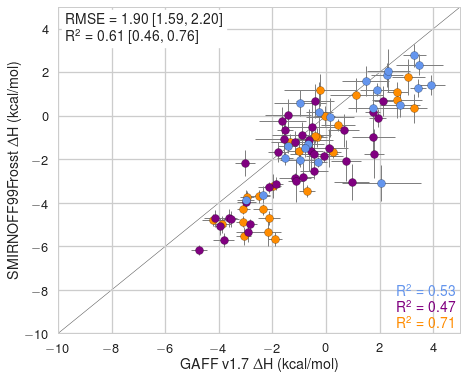

In [105]:
# SMIRNOFF99Frosst vs. GAFF v1.7

df = smirnoff.merge(bgbg, on=["System", "Type"], suffixes=("_smirnoff",
                                                                "_bgbg_tip3p"))
assert(len(df) == 86)

artist = scatter(df, 
        x="Delta H_bgbg_tip3p",
        y="Delta H_smirnoff",
        xerr="H_SEM_bgbg_tip3p",
        yerr="H_SEM_smirnoff",
        xlabel=r"GAFF v1.7 $\Delta$H (kcal/mol)",
        ylabel=r"SMIRNOFF99Frosst $\Delta$H (kcal/mol)",
        colors=colors,
        name="SMIRNOFF99Frosst-vs-GAFF-v1.7-dH.pdf",
        statistics_file_prefix="bgbg_smirnoff_by_orientation_dH_statistics")

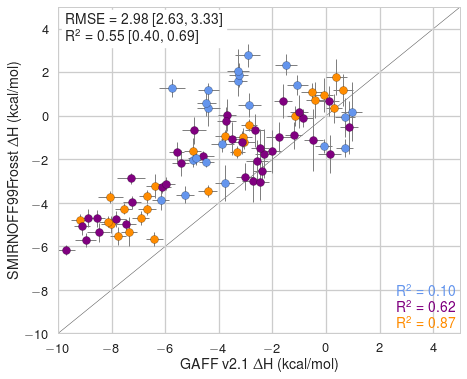

In [106]:
# SMIRNOFF99Frosst vs. GAFF v2.1

df = smirnoff.merge(bg2bg2, on=["System", "Type"], suffixes=("_smirnoff",
                                                                "_bg2bg2_tip3p"))
assert(len(df) == 86)

scatter(df, 
        x="Delta H_bg2bg2_tip3p",
        y="Delta H_smirnoff",
        xerr="H_SEM_bg2bg2_tip3p",
        yerr="H_SEM_smirnoff",
        xlabel=r"GAFF v2.1 $\Delta$H (kcal/mol)",
        ylabel=r"SMIRNOFF99Frosst $\Delta$H (kcal/mol)",
        colors=colors,
        name="SMIRNOFF99Frosst-vs-GAFF-v2.1-dH.pdf",
        statistics_file_prefix="bg2bg2_smirnoff_by_orientation_dH_statistics")

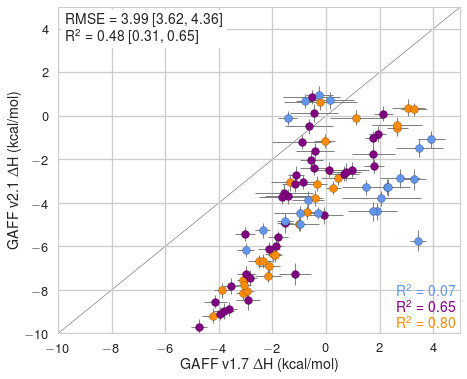

In [107]:
# GAFF v1.7 vs. GAFF v2.1

df = bgbg.merge(bg2bg2, on=["System", "Type"], suffixes=("_bgbg_tip3p",
                                                                "_bg2bg2_tip3p"))
assert(len(df) == 86)

scatter(df, 
        x="Delta H_bgbg_tip3p",
        y="Delta H_bg2bg2_tip3p",
        xerr="H_SEM_bgbg_tip3p",
        yerr="H_SEM_bg2bg2_tip3p",
        xlabel=r"GAFF v1.7 $\Delta$H (kcal/mol)",
        ylabel=r"GAFF v2.1 $\Delta$H (kcal/mol)",
        colors=colors,
        name="GAFF-v2.1-vs-GAFF-v1.7-dH.pdf",
        statistics_file_prefix="bgbg_bg2bg2_by_orientation_dH_statistics")

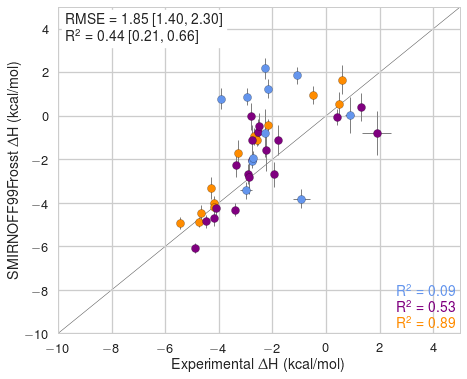

In [111]:
# SMIRNOFF99Frosst vs. Experiment

df = smirnoff_combined.merge(experimental, on=["System"], suffixes=("_smirnoff",
                                                                "_experiment"))
assert(len(df) == 43)

scatter(df, 
        x="Delta H_experiment",
        y="Delta H_smirnoff",
        xerr="H_SEM_experiment",
        yerr="H_SEM_smirnoff",
        xlabel=r"Experimental $\Delta$H (kcal/mol)",
        ylabel=r"SMIRNOFF99Frosst $\Delta$H (kcal/mol)",
        colors=colors,
        name="SMIRNOFF99Frosst-vs-Experiment-dH.pdf",
        statistics_file_prefix="experimental_smirnoff_dH_statistics")

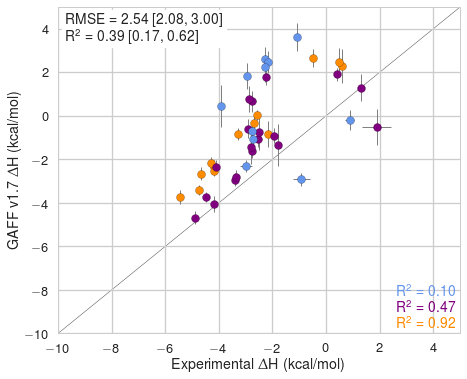

In [112]:
# GAFF v1.7 vs. Experiment

df = bgbg_combined.merge(experimental, on=["System"], suffixes=("_bgbg",
                                                                "_experiment"))
assert(len(df) == 43)

scatter(df, 
        x="Delta H_experiment",
        y="Delta H_bgbg",
        xerr="H_SEM_experiment",
        yerr="H_SEM_bgbg",
        xlabel=r"Experimental $\Delta$H (kcal/mol)",
        ylabel=r"GAFF v1.7 $\Delta$H (kcal/mol)",
        colors=colors,
        name="GAFF-v1.7-vs-Experiment-dH.pdf",
        statistics_file_prefix="experimental_bgbg_dH_statistics")

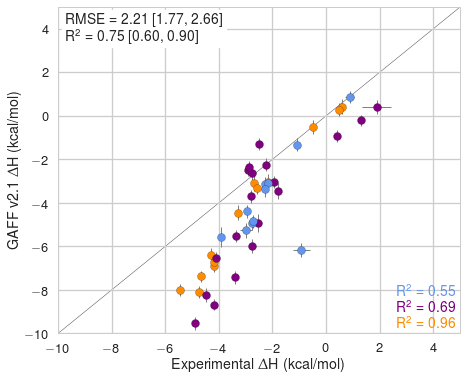

In [113]:
# GAFF v2.1 vs. Experiment

df = bg2bg2_combined.merge(experimental, on=["System"], suffixes=("_bg2bg2",
                                                                "_experiment"))
assert(len(df) == 43)

scatter(df, 
        x="Delta H_experiment",
        y="Delta H_bg2bg2",
        xerr="H_SEM_experiment",
        yerr="H_SEM_bg2bg2",
        xlabel=r"Experimental $\Delta$H (kcal/mol)",
        ylabel=r"GAFF v2.1 $\Delta$H (kcal/mol)",
        colors=colors,
        name="GAFF-v2.1-vs-Experiment-dH.pdf",
        statistics_file_prefix="experimental_bg2bg2_dH_statistics")

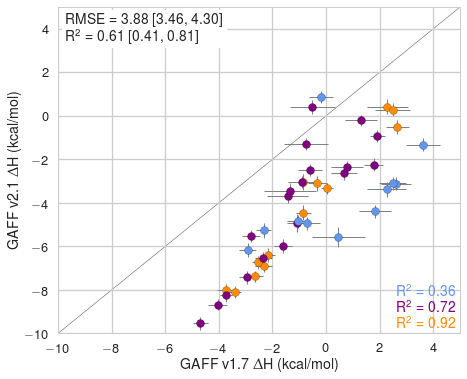

In [114]:
# GAFF v1.7 vs. GAFF v2.1

df = bg2bg2_combined.merge(bgbg_combined, on=["System", "Type"], suffixes=("_bg2bg2",
                                                                "_bgbg"))
assert(len(df) == 43)

scatter(df, 
        x="Delta H_bgbg",
        y="Delta H_bg2bg2",
        xerr="H_SEM_bgbg",
        yerr="H_SEM_bg2bg2",
        xlabel=r"GAFF v1.7 $\Delta$H (kcal/mol)",
        ylabel=r"GAFF v2.1 $\Delta$H (kcal/mol)",
        colors=colors,
        name="GAFF-v2.1-vs-GAFF-v1.7-combined-dH.pdf",
        statistics_file_prefix="bgbg_bg2bg2_dH_statistics")